# P4: Advanced Lane Finding

## Contents
1. Camera Calibration
2. Pipeline (test images)
3. Pipeline (video)
4. Discussion

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Camera Calibration

define function for undistortion

In [2]:
def cal_undistort(img):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('./camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img_cal = cv2.imread(fname)
        gray = cv2.cvtColor(img_cal,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

(1/1): Provide an example of a distortion corrected calibration image

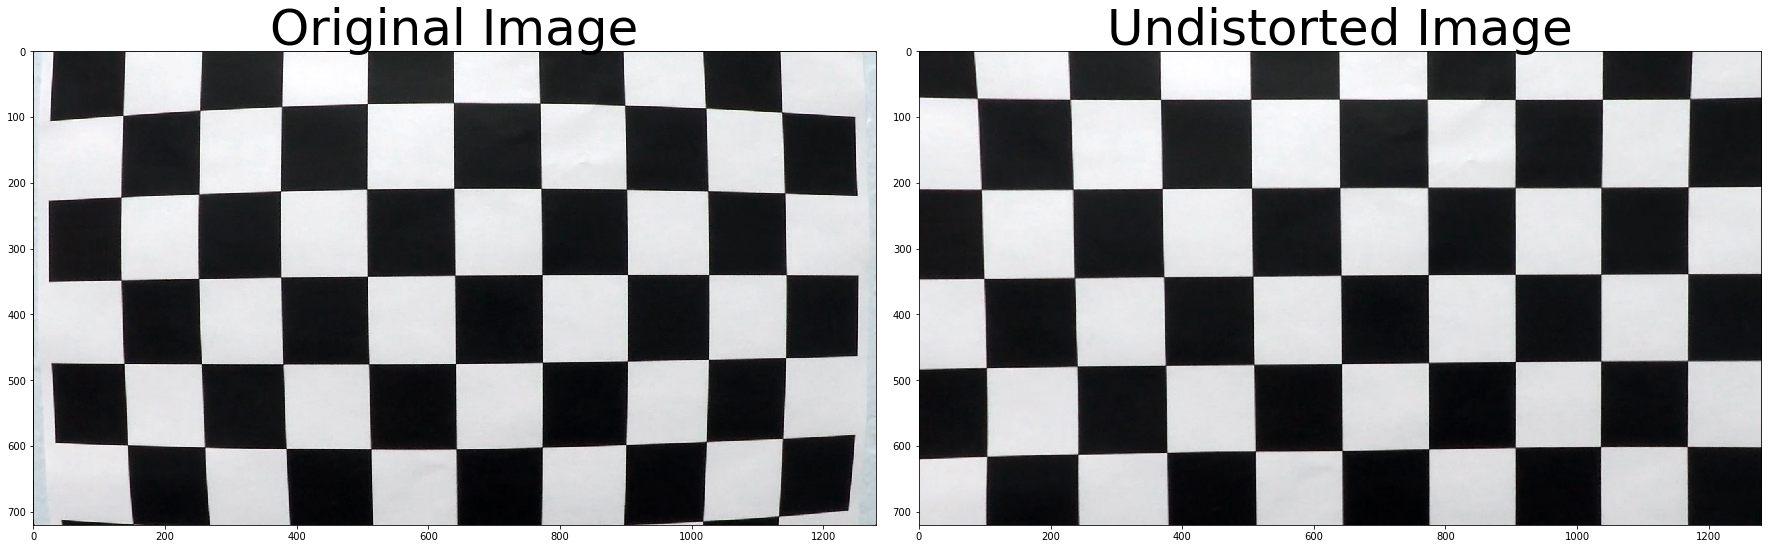

In [3]:
img = cv2.imread('./camera_cal/calibration1.jpg')
undistorted = cal_undistort(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 2. Pipeline (test images)

#### (1/6): Provide an example of a distortion-corrected image

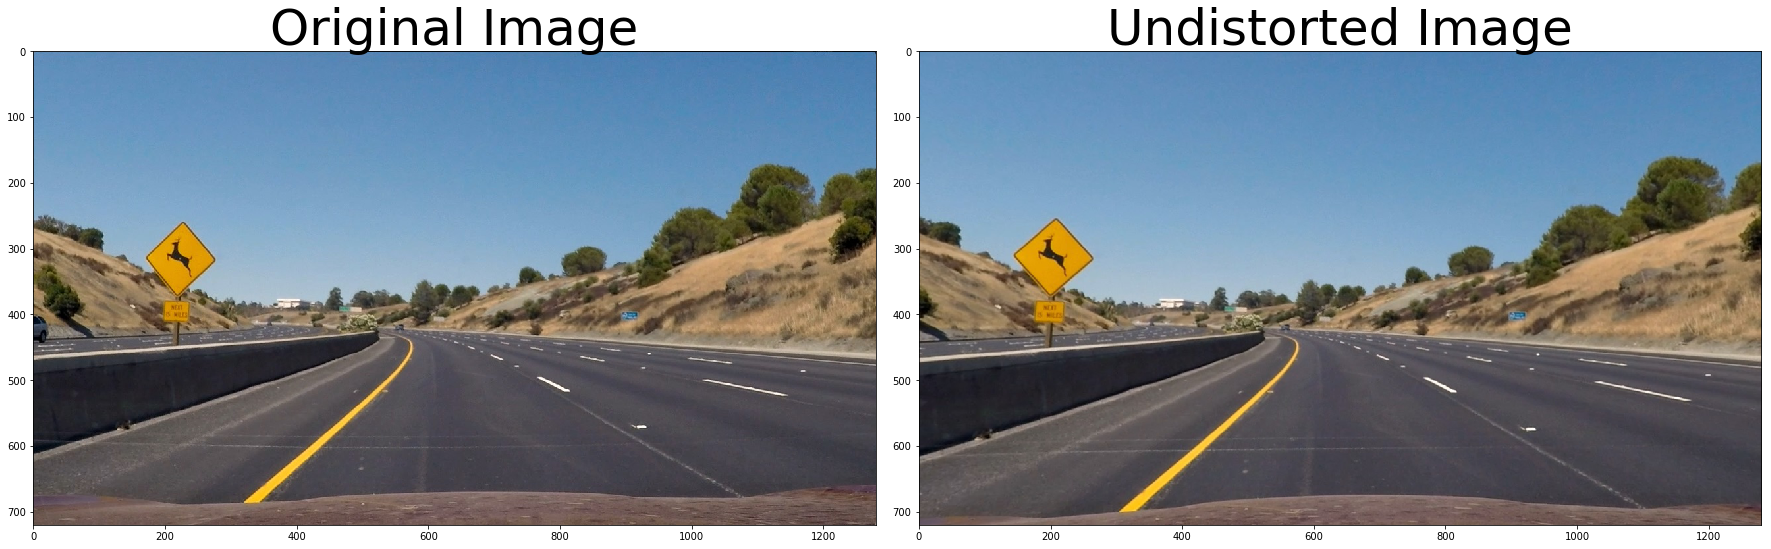

In [4]:
img = cv2.imread('./test_images/test2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undistorted = cal_undistort(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### (2/6): Provide an example of binary image results (gradient)

define functions for gradients

In [5]:
def abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=35):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take the derivative in x or y given orient = 'x' or 'y'
    if(orient=='x'):sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif(orient=='y'):sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a mask of 1's where the scaled gradient magnitude is > min & < max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the magnitude 
    abs_sobel = np.sqrt(sobelx*sobelx + sobely*sobely)
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(direction)
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return binary_output

Apply them

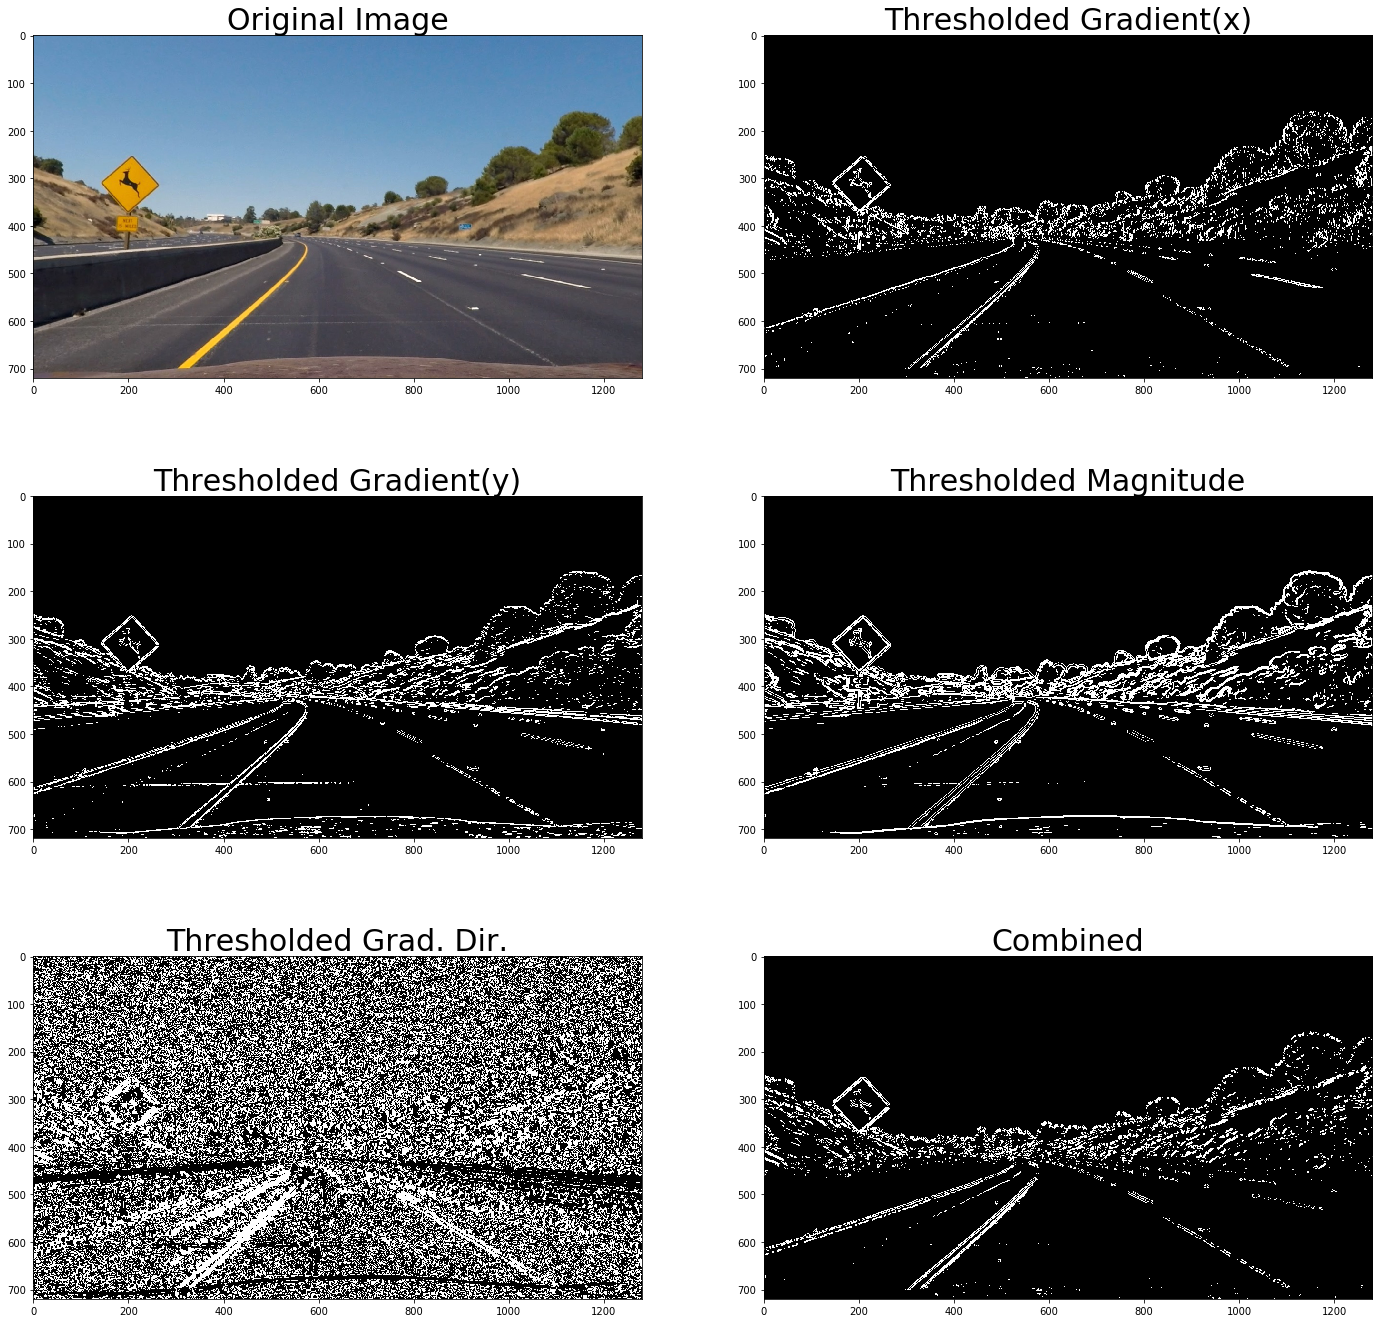

In [6]:
# Run the function
grad_x = abs_sobel_thresh(undistorted, orient='x', thresh_min=20, thresh_max=100)
grad_y = abs_sobel_thresh(undistorted, orient='y', thresh_min=20, thresh_max=100)
mag_binary = mag_thresh(undistorted, sobel_kernel=9, mag_thresh=(30, 100))
dir_binary = dir_threshold(undistorted, sobel_kernel=15, thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[((grad_x == 1) & (grad_y == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Plot the result
f, axes = plt.subplots(3, 2, figsize=(24, 24))

axes[0, 0].imshow(undistorted)
axes[0, 0].set_title('Original Image', fontsize=30)
axes[0, 1].imshow(grad_x, cmap='gray')
axes[0, 1].set_title('Thresholded Gradient(x)', fontsize=30)

axes[1, 0].imshow(grad_y, cmap='gray')
axes[1, 0].set_title('Thresholded Gradient(y)', fontsize=30)
axes[1, 1].imshow(mag_binary, cmap='gray')
axes[1, 1].set_title('Thresholded Magnitude', fontsize=30)

axes[2, 0].imshow(dir_binary, cmap='gray')
axes[2, 0].set_title('Thresholded Grad. Dir.', fontsize=30)
axes[2, 1].imshow(combined, cmap='gray')
axes[2, 1].set_title('Combined', fontsize=30)

Sobel x, gradient threshold is enough compared with combined one

#### (2/6): Provide an example of binary image results (color)

define function for HLS selection

In [7]:
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

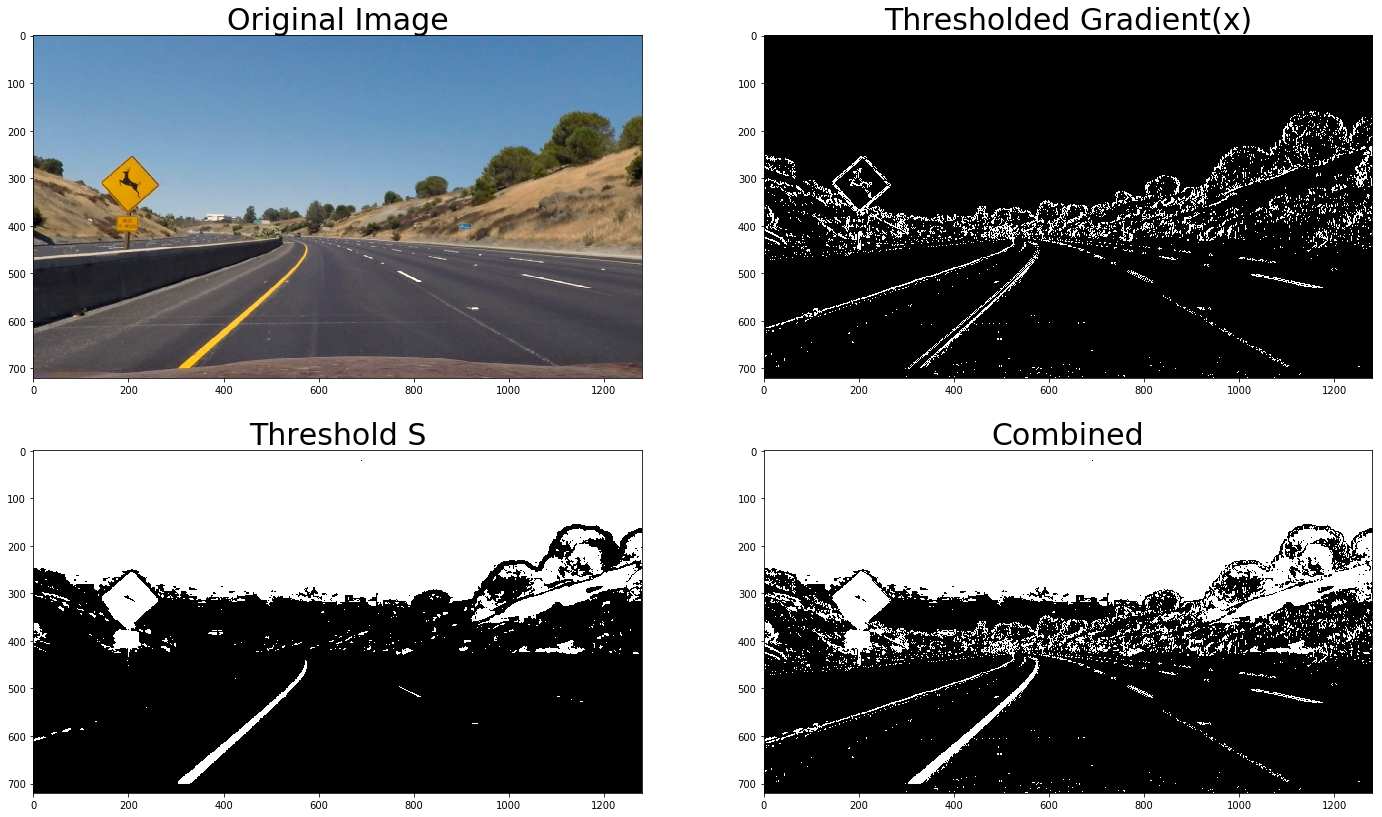

In [8]:
s_binary = hls_select(undistorted, thresh=(90, 255))

# Combine the two binary thresholds
combined_binary = np.zeros_like(grad_x)
combined_binary[(s_binary == 1) | (grad_x == 1)] = 1

# Plot the result
f, axes = plt.subplots(2, 2, figsize=(24, 14))

axes[0, 0].imshow(undistorted)
axes[0, 0].set_title('Original Image', fontsize=30)
axes[0, 1].imshow(grad_x, cmap='gray')
axes[0, 1].set_title('Thresholded Gradient(x)', fontsize=30)

axes[1, 0].imshow(s_binary, cmap='gray')
axes[1, 0].set_title('Threshold S', fontsize=30)
axes[1, 1].imshow(combined_binary, cmap='gray')
axes[1, 1].set_title('Combined', fontsize=30)

#### (3/6): Provide an example of a transformed image

In [9]:
def warper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped

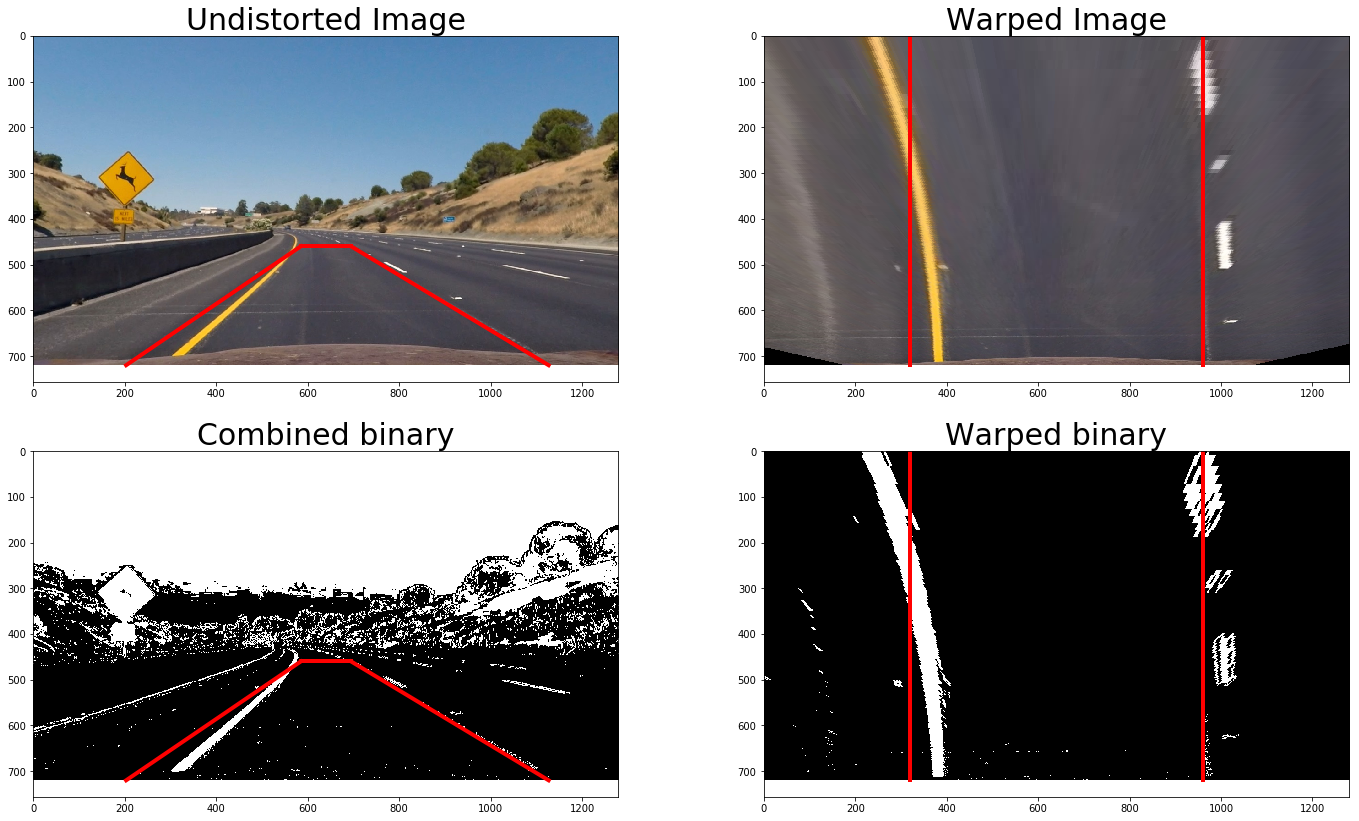

In [10]:
#source
src = np.float32([[585, 460], [203, 720], [1127, 720], [695, 460]])
#destination
dst = np.float32([[320, 0], [320, 720], [960, 720], [960, 0]])

bird_view = warper(undistorted, src, dst)
bird_binary = warper(combined_binary, src, dst)

# Plot the result
f, axes = plt.subplots(2, 2, figsize=(24, 14))

axes[0, 0].imshow(undistorted)
axes[0, 0].set_title('Undistorted Image', fontsize=30)
axes[0, 0].plot([src[0][0], src[1][0]], [src[0][1], src[1][1]], 'r-', lw=4)
axes[0, 0].plot([src[0][0], src[3][0]], [src[0][1], src[3][1]], 'r-', lw=4)
axes[0, 0].plot([src[2][0], src[3][0]], [src[2][1], src[3][1]], 'r-', lw=4)

axes[0, 1].imshow(bird_view)
axes[0, 1].set_title('Warped Image', fontsize=30)
axes[0, 1].plot([dst[0][0], dst[1][0]], [dst[0][1], dst[1][1]], 'r-', lw=4)
axes[0, 1].plot([dst[2][0], dst[3][0]], [dst[2][1], dst[3][1]], 'r-', lw=4)

axes[1, 0].imshow(combined_binary, cmap='gray')
axes[1, 0].set_title('Combined binary', fontsize=30)
axes[1, 0].plot([src[0][0], src[1][0]], [src[0][1], src[1][1]], 'r-', lw=4)
axes[1, 0].plot([src[0][0], src[3][0]], [src[0][1], src[3][1]], 'r-', lw=4)
axes[1, 0].plot([src[2][0], src[3][0]], [src[2][1], src[3][1]], 'r-', lw=4)

axes[1, 1].imshow(bird_binary, cmap='gray')
axes[1, 1].set_title('Warped binary', fontsize=30)
axes[1, 1].plot([dst[0][0], dst[1][0]], [dst[0][1], dst[1][1]], 'r-', lw=4)
axes[1, 1].plot([dst[2][0], dst[3][0]], [dst[2][1], dst[3][1]], 'r-', lw=4)

#### (4/6): Identify lane lines & fit their positions with a polynominal

In [14]:
def blind_search(bird_binary, nwindows=9, margin=60, minpix=50):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(bird_binary[bird_binary.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((bird_binary, bird_binary, bird_binary))*255
    
    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint]) 
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    window_height = np.int(bird_binary.shape[0]/nwindows) # Set height of windows
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bird_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = bird_binary.shape[0] - (window+1)*window_height
        win_y_high = bird_binary.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
    
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) 
                          & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) 
                           & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    ploty = np.linspace(0, bird_binary.shape[0]-1, bird_binary.shape[0] )
    
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to show the lane width
    window_img = np.zeros_like(out_img)
    
    # Color in left and right line pixels
    window_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    window_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    left_line_window = np.array([np.flipud(np.transpose(np.vstack([left_fitx, ploty])))])
    right_line_window = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
    road_pts = np.hstack((left_line_window, right_line_window))
    
    # Create an image to show the lane width
    window2_img = np.zeros_like(out_img)
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window2_img, np.int_([road_pts]), (0,255, 0))
    result = cv2.addWeighted(window_img, 1, window2_img, 0.3, 0)
    
    # Define conversions in x and y from pixels space to meters
    y_eval = bird_binary.shape[0]//2 # any value from 0 to height of image(720) is ok
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    position = bird_binary.shape[1]/2
    center = (leftx_current + rightx_current)/2
    position_real = (position - center)*xm_per_pix
    
    return result, left_curverad, right_curverad, position_real, left_fitx, right_fitx

(720, 0)

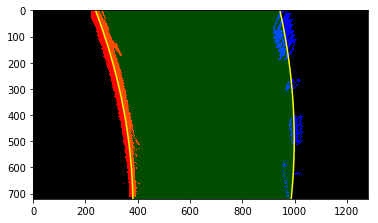

In [16]:
result, l_curve, r_curve, position, left_fitx, right_fitx = blind_search(bird_binary, nwindows=9, margin=60, minpix=50)
ploty = np.linspace(0, bird_binary.shape[0]-1, bird_binary.shape[0] )
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

#### (5/6): calculate the radius of curvature

In [17]:
print(l_curve, 'm', r_curve, 'm', position, 'm')

654.789629008 m 733.310717885 m 0.17442857142857143 m


#### (6/6): plotted back down onto the road

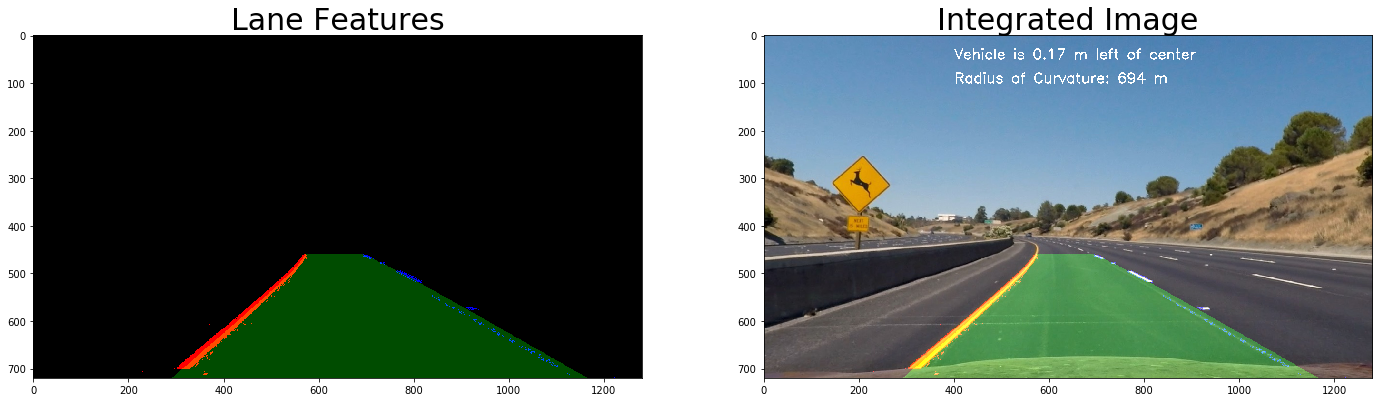

In [18]:
lane_features = warper(result, dst, src)
Integrated = cv2.addWeighted(undistorted, 1, lane_features, 1, 0)

font = cv2.FONT_HERSHEY_SIMPLEX
text = "Radius of Curvature: {} m".format(int(l_curve+r_curve)//2)
cv2.putText(Integrated,text,(400,100), font, 1,(255,255,255),2)
text = "Vehicle is {:.2f} m left of center".format(position)
cv2.putText(Integrated,text,(400,50), font, 1,(255,255,255),2)

# Plot the result
f, axes = plt.subplots(1, 2, figsize=(24, 14))

axes[0].imshow(lane_features)
axes[0].set_title('Lane Features', fontsize=30)

axes[1].imshow(Integrated)
axes[1].set_title('Integrated Image', fontsize=30)

## 3. Pipeline (video)

In [19]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [20]:
def process_image(img):
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    grad_x = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100)
    s_binary = hls_select(img, thresh=(100, 255))
    combined_binary = np.zeros_like(grad_x)
    combined_binary[(s_binary == 1) | (grad_x == 1)] = 1
    
    #source
    src = np.float32([[585, 460], [203, 720], [1127, 720], [695, 460]])
    #destination
    dst = np.float32([[320, 0], [320, 720], [960, 720], [960, 0]])
    bird_binary = warper(combined_binary, src, dst)
    lane_features_warped, l_curve, r_curve, position, left_fitx, right_fitx = blind_search(bird_binary, nwindows=9, margin=60, minpix=50)
    lane_features = warper(lane_features_warped, dst, src)
    result = cv2.addWeighted(img, 1, lane_features, 1, 0)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Radius of Curvature: {} m".format(int(l_curve+r_curve)//2)
    cv2.putText(result,text,(400,100), font, 1,(255,255,255),2)
    text = "Vehicle is {:.2f} m left of center".format(position)
    cv2.putText(result,text,(400,50), font, 1,(255,255,255),2)

    return result

In [21]:
test_output = 'project_video_output.mp4'
clip1 = VideoFileClip('project_video.mp4')
test_clip = clip1.fl_image(process_image) 
%time test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [01:25<00:00, 14.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 8min 1s, sys: 4.79 s, total: 8min 6s
Wall time: 1min 26s


## 4. Discussion

In this algorithm, base point is derived by np.argmax(), and position is calculated by mean. But there are lots of pattern of lane in the world, and if right / left lane is not single line but multiple lines, this algorithm may not be suitable.